# INTRO

Для заказчика необходимо найти решение определения уровня сложности английского языка в фильмах по субтитрам.

Заказчик предоставил данные:
- английские словари Oxford, в которых слова распределены по уровню сложности
- набор файлов-субтитров, рассортированных по каталогам в соответствии с уровнем сложности
- excel файл со список несортированных фильмов и указанием их уровня

Цель:
- создание модели определения уровня сложности

Задачи:
- изучение и обработка предоставленного материала
- обработка текста субтитров и подготовка для машинного обучения
- расчет и добавление дополнительных признаков
- тестирование модели и подбор гиперпараметров
- выделение наиболее удачных признаков
- обучение оптимальной модели на датасете с наиболее полезными признаками
- создание приложения на платформе streamlit для демонстрации решения



In [1]:
import os
import re
import warnings

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump, load

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

import xgboost

try:
    import spacy
except:
    !pip install spacy
    !python -m spacy download en
    import spacy

try:
    import chardet
except:
    !pip install chardet
    import chardet

try:
    from pypdf import PdfReader
except:
    !pip install pypdf
    from pypdf import PdfReader

try:
    import pysrt
except:
    !pip install pysrt
    import pysrt



In [2]:
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
nlp = spacy.load("en_core_web_sm")

SCORES_PATH    = 'English_level/English_scores'
SUBTITLES_PATH = 'English_level/English_scores/Subtitles_all'
OXFORD_PATH    = 'English_level/Oxford_CEFR_level'

ENGLISH_LEVELS = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']

RANDOM_STATE = 7

# LOAD DATA

## The Oxford core by CEFR level

В словарях Oxford 3000 и 5000 содержатся наиболее важные слова, которые должен знать каждый, кто учит английский.

Словарь Oxford соответствует стандартам CEFR – The Common European Framework of Reference for Languages. Это общеевропейские компетенции владения иностранным языком: изучение, преподавание, оценка — система уровней владения иностранным языком, используемая в Европейском Союзе.

У нас словари представлены в виде pdf-файлов.
- прочитаем их,
- разобьем на строки,
- выделим слова,
- определим уровень
- сохраним, из какого словаря взяли слово
- удалим дубликаты, оставим те случаи, где слову присвоена более высокая сложность
- выгрузим в joblib для дальнейшего использования в приложении Streamlit

In [3]:
def process_pdf(content):
    
    current_level = ''
    words_by_level = {key:[] for key in ENGLISH_LEVELS}
    
    for line in content:
        line = line.strip()

        if 'Oxford' in line or 'English' in line:
            pass
        
        elif line in ENGLISH_LEVELS:
            level = line
            
        elif ' ' in line:
            line = re.sub(r'\d|,', '', line.lower())   # remove digits and commas and transform to lowercase
            words_by_level[level] += [line.split()[0]] #get the first occurency in line as word
            
        else:
            pass
    
    return words_by_level


content = []
oxford_words = pd.DataFrame(columns=['word', 'level', 'source', 'type'])

# load all pdfs
for dirname, _, filenames in os.walk(OXFORD_PATH):
    for filename in filenames:
        print(filename)
        reader = PdfReader(f'{OXFORD_PATH}/{filename}')
        for page in reader.pages:
            content += page.extract_text().splitlines()
        processed = process_pdf(content)
        for level in processed:
            dict_type = 'us' if 'American' in filename else 'uk'
            oxford_words = pd.concat([oxford_words,
                                      pd.DataFrame({'word'   : processed[level],
                                                    'level'  : level,
                                                    'source' : filename,
                                                    'type'   : dict_type
                                                   })
                                     ])

# sort words and keep unique with higher levels
oxford_words = oxford_words.sort_values(by=['word', 'level'], ascending=True)
oxford_words = oxford_words.drop_duplicates(subset=['word'], keep='last')

# после сортировки и удаления дубликатов остался только американский инглиш
# похоже там все уровни слов считаются выше

oxford_words.groupby('level') \
            .agg({'word':'count', 'source': 'unique'}) \
            .style.format({'word':'{:,.0f} слов'})


American_Oxford_3000_by_CEFR_level.pdf
The_Oxford_3000_by_CEFR_level.pdf
The_Oxford_5000_by_CEFR_level.pdf
American_Oxford_5000_by_CEFR_level.pdf


,word,source
level,,
A1,735 слов,['American_Oxford_5000_by_CEFR_level.pdf']
A2,747 слов,['American_Oxford_5000_by_CEFR_level.pdf']
B1,758 слов,['American_Oxford_5000_by_CEFR_level.pdf']
B2,"1,446 слов",['American_Oxford_5000_by_CEFR_level.pdf']
C1,"1,198 слов",['American_Oxford_5000_by_CEFR_level.pdf']


In [5]:
dump(oxford_words,'english_level_oxford.joblib')

['english_level_oxford.joblib']

## Subtitles .srt

Субтитры у нас представлены в виде файлов .srt – это текстовые файлы, в которых информация представлены в таком виде:

        18
        00:04:59,796 --> 00:04:59,921
        - ( police radio chatter )
        - Man: What's the difference
    
То есть номер реплики, время и текст.

Файлы рассортированы по папкам, соответствующим уровням сложности языка.

Просканируем все файлы построчно:
- удалим из текста по возможности тэги, скобки, указания говорящего лица
- нетекстовые знаки, 
- лишние пробелы и переводы строки

Сохраним временные характеристики реплик:
- длительность реплики
- скорость речи в знаках в секунду
- скорость речи в словах в секунду

Соберем все в виде датасета для дальнейшей обработки.
    

In [6]:
# process line
def process_line(line):
    if re.search(r'[A-Za-z]',line): 
        line = line.lower()
        line = re.sub(r'\n', ' ', line)                            # remove new lines
        line = re.sub(r'- ', ' ', line)                            # remove dash
        line = re.sub(r'\<[^\<]+?\>', '', line)                    # remove html tags
        line = re.sub(r'\([^\(]+?\)', '', line)                    # remove () parenthesis
        line = re.sub(r'\[[^\[]+?\]', '', line)                    # remove [] parenthesis
        line = re.sub(r'^([\w#\s]+\:)', ' ', line)                 # remove speaker tag
        line = re.sub(r'[^[:alnum:][:punct:][:blank:]]',' ', line) # remove all other non-speach shars
        line = re.sub(r'\s\s+', ' ', line).strip()                 # remove extra spaces
    return line


# process text line by line   
def process_text(content):
    text = []
    duration  = []
    charsrate = []
    wordsrate  = []
    for item in content:
        if not hasattr(item, 'duration'):
            print('no')
        if item.duration.ordinal>0:
            line = process_line(item.text_without_tags)
            text.append(line)
            duration.append(item.duration.ordinal/1000)
            charsrate.append(item.characters_per_second)
            wordsrate.append(len(line.split())/item.duration.ordinal*1000.0)
    return ' '.join(text), duration, charsrate, wordsrate


# process file
def process_srt(dirname, filename):
    global count
    if not filename.endswith('.srt'):                        # skip non srt files
        print('посторонний файл', filename)
        return False
    fullpath = os.path.join(dirname,filename)
    try:
        enc = chardet.detect(open(fullpath, "rb").read())['encoding']
        content = pysrt.open(fullpath, encoding=enc)
    except:
        print('не прочиталось', filename)
        return False
    return process_text(content)                            # clean text and return


# movies dataset template
movies = pd.DataFrame(columns=['filename', 
                               'content', 
                               'duration', 
                               'charsrate', 
                               'wordsrate', 
                               'level', 
                               'lemmas'] + ENGLISH_LEVELS + [l+'ratio' for l in ENGLISH_LEVELS]
                     )

# recursive walk through dirs
for dirname, _, filenames in os.walk(SUBTITLES_PATH):
    for filename in filenames:
        level  = dirname.split('/')[-1]                   # get level name from dir
        result = process_srt(dirname, filename)           # process file
        if result:                                        # add movie to dataframe
            subs, duration, charsrate, wordsrate = result
            movies.loc[len(movies)] = \
                {'filename' : filename.replace('.srt', ''),
                 'content'  : subs,
                 'duration' : duration, 
                 'charsrate': charsrate, 
                 'wordsrate': wordsrate, 
                 'level'    : level
                }

movies.head(3)


посторонний файл .DS_Store
посторонний файл .DS_Store


,filename,content,duration,charsrate,wordsrate,level,lemmas,A1,A2,B1,B2,C1,C2,A1ratio,A2ratio,B1ratio,B2ratio,C1ratio,C2ratio
0,"Crown, The S01E01 - Wolferton Splash.en","in seeking his british nationalization, his ro...","[4.56, 3.4, 4.28, 4.0, 6.56, 1.0, 2.4, 1.0, 2....","[12.500000000000002, 11.176470588235295, 10.74...","[1.7543859649122808, 2.058823529411765, 1.4018...",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Suits.Episode 1- Denial,you're the most amazing woman i have ever met....,"[2.034, 4.069, 1.901, 1.334, 2.201, 1.5, 1.667...","[22.123893805309738, 9.584664536741213, 11.572...","[4.424778761061947, 1.9660850331776847, 1.5781...",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Crazy4TV.com - Suits.S06E06.720p.BluRay.x265.H...,i've been after sutter for three years now. t...,"[1.46, 1.21, 1.46, 1.71, 1.71, 1.752, 1.543, 2...","[10.95890410958904, 34.710743801652896, 26.027...","[0.0, 6.6115702479338845, 5.47945205479452, 2....",B2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Excel labels processing

Часть файлов лежит в общем каталоге без указания уровня сложности. Для них заказчик предоставил excel-файл со списком фильмов и уровнями.
 
Загрузим файл и изучим его:
- удалим дубликаты
- поправим несовпадения названий
- из указанных уровней оставим более сложный вариант
- удалим фильмы, для которых нет информации по уровню сложности

In [7]:
movie_labels = pd.read_excel(f'{SCORES_PATH}/movies_labels.xlsx', index_col='id')
movie_labels.info()
movie_labels.columns = ['movie', 'level']
print('\nДубликаты полные', movie_labels.duplicated().sum())
print('Дубликаты в названиях фильмов', movie_labels.movie.duplicated().sum())
movie_labels = movie_labels.drop_duplicates()
movie_labels.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   241 non-null    object
 1   Level   241 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB

Дубликаты полные 2
Дубликаты в названиях фильмов 4


,movie,level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


In [8]:
# correct some mistakes in movies names
movie_labels.movie = movie_labels.movie.str.replace('.srt', '', regex=False)
movie_labels.loc[movie_labels.movie == 'Up (2009)', 'movie'] = 'Up(2009)'
movie_labels.loc[movie_labels.movie == 'The Grinch', 'movie'] = 'The.Grinch'

# удалим из level лишние символы, разделители оставим пробел
# из мультиуровней выберем наибольший
movie_labels.level = movie_labels.level \
                                 .str.replace(',', '', regex=False) \
                                 .str.replace('+', '', regex=False) \
                                 .str.replace('/', ' ', regex=False) \
                                 .str.split().transform(lambda x: max(x))

movie_labels.groupby('level').count().sort_index().style.format({'movie':'{:.0f} фильмов'})


,movie
level,
A2,32 фильмов
B1,58 фильмов
B2,109 фильмов
C1,40 фильмов


In [9]:
# excel processing
for row in movie_labels.itertuples():

    n = movies.loc[movies.filename.str.contains(row.movie, regex=False)].shape[0]

    if n == 0:
        print('не найден текст', row.movie)

    elif n == 1:
        selected_movie_level = movies.loc[
            movies.filename.str.contains(row.movie, regex=False), 'level'].values[0]

        if selected_movie_level == 'Subtitles':         # replace Subtitles with excel level
             movies.loc[
                 movies.filename.str.contains(row.movie, regex=False), 'level'] = row.level

        elif selected_movie_level != row.level:          # replace with max current level or excel
             movies.loc[
                 movies.filename.str.contains(row.movie, regex=False), 'level'
             ] = max(selected_movie_level, row.level)

    else:
        print('не единственный текст, уже есть', row.movie)


movies = movies[movies.level!='Subtitles']


не найден текст The Secret Life of Pets.en
не найден текст Glass Onion
не найден текст Matilda(2022)
не найден текст Bullet train
не найден текст Thor: love and thunder
не найден текст Lightyear


## Lemmatization and feature engineering

Подготовим текст для машинного обучения:
- фильтруем имена собственные, стоп-слова, пунктуацию, цифры, урлы
- выполним лемматизацию – приведение слов к нормальной форме
- выделим морфологическую разметку

Добавим числовые признаки.

Слова (леммы):
- общее количество
- количество уникальных слов
- доля уников от общего количества

Предложения:
- количество предложений
- количество слов в предложениях
- медианная длина предложения

Сложность:
- подсчитаем количество уникальных слов каждого уровня
- долю слов каждой сложности относительно общего количества уников

Целевой признак перекодируем в порядковые числа от 0 до 5.

In [10]:
%%time
# если выделять и леммы, и части речи, то так быстрее – 
# в один проход их отфильтровать и потом разделить
movies['lemmas_pos'] = movies.content.transform(lambda x: [[token.lemma_ , token.pos_]
                                                           for token in nlp(re.sub(r'-', '', x))
                                                           if  not token.ent_type 
                                                           and not token.is_punct
                                                           and not token.is_currency
                                                           and not token.is_digit
                                                           and not token.is_space
                                                           and not token.is_stop
                                                           and not token.like_num
                                                           and not token.like_url
                                                           and not token.like_email
                                                           and token.pos_!='INTJ'
                                                          ])

CPU times: user 6min 56s, sys: 14.5 s, total: 7min 10s
Wall time: 7min 16s


In [11]:
movies['lemmas'] = movies.lemmas_pos.transform(lambda x: ' '.join(item[0] for item in x))
movies['pos']    = movies.lemmas_pos.transform(lambda x: ' '.join(item[1] for item in x))

In [12]:
%%time
# sentences
movies['sents'] = movies.content.transform(lambda x: list(nlp(x).sents))


CPU times: user 6min 48s, sys: 8.38 s, total: 6min 57s
Wall time: 6min 58s


In [13]:
# stop words count and ratio
movies['stops'] = movies.content.transform(lambda x: sum(token.is_stop for token in nlp(x)))
movies['total'] = movies.content.transform(lambda x: len(x.split()))
movies['stops_ratio'] = movies.stops/movies.total

In [14]:
# total lemmas count
# and unique lemmas count
# and unique ratio
movies['lemmas_count']  = movies.lemmas.transform(lambda x: len(x.split()))
movies['lemmas_unique'] = movies.lemmas.transform(lambda x: len(set(x.split())))
movies['lemmas_unique_ratio'] = movies.lemmas_unique / movies.lemmas_count


In [15]:
# count of sentences
# lengths of sentences
# median length
movies['sents_count']  = movies.sents.transform(lambda x: len(x))
movies['sents_length'] = movies.sents.transform(lambda x: [len(sent) for sent in x])
movies['sents_median'] = movies.sents_length.transform(lambda x: np.median(x))


In [16]:
# oxford words in movies lemmas
def count_words_by_level(row):
    row_lemmas = row.lemmas.split()
    total_score = oxford_words.loc[oxford_words.word.isin(row_lemmas)] \
                              .groupby('level').word.count().to_dict()
    row[total_score.keys()] = total_score
    return row

movies = movies.apply(count_words_by_level, axis=1)


In [17]:
# ratio oxford words in content
for l in ENGLISH_LEVELS:
    movies[l+'ratio'] = movies[l]/movies.lemmas_unique


In [18]:
# count words by length
# and ratio to total count
for i in range(1,10):
    equal_col = 'len_equal_'+str(i)
    more_col  = 'more_than_'+str(i)
    less_col  = 'less_than_'+str(i)
    
    movies[equal_col] = movies.lemmas.transform(lambda x: sum(len(word)==i for word in x.split()))
    movies[more_col]  = movies.lemmas.transform(lambda x: sum(len(word)>i for word in x.split()))
    movies[less_col]  = movies.lemmas.transform(lambda x: sum(len(word)<i for word in x.split()))
    
    movies[equal_col + 'ratio'] = movies[equal_col] / movies.lemmas_count
    movies[more_col + 'ratio']  = movies[more_col] / movies.lemmas_count
    movies[less_col + 'ratio']  = movies[less_col] / movies.lemmas_count
    

In [19]:
# speed rates in seconds
for c in ['duration', 'charsrate', 'wordsrate']:
    movies[c+'_median'] = movies[c].transform(lambda x: np.median(x))


In [20]:
# encode level to ordinal values
# fill missing values
# export data movies to csv
movies['target'] = movies.level.map({'A1':0, 'A2':1, 'B1':2, 'B2':3, 'C1':4, 'C2':5})
movies = movies.fillna(0)
movies.to_csv('movies_df.csv', index=False)

try:
    os.system('say "data processing completed"')
except:
    pass


# MODELS TEST

In [21]:
movies = pd.read_csv('movies_df.csv')


In [22]:
lemmas_num = ['lemmas_count', 'lemmas_unique', 'lemmas_unique_ratio']

levels_ratio = [l+'ratio' for l in ENGLISH_LEVELS]

length_equal = ['len_equal_'+str(i) for i in range(1,10)]
length_more  = ['more_than_'+str(i) for i in range(1,10)]
length_less  = ['less_than_'+str(i) for i in range(1,10)]

sents_num = ['sents_count', 'sents_median']

equal_ratio = [c+'ratio' for c in length_equal]
more_ratio  = [c+'ratio' for c in length_more]
less_ratio  = [c+'ratio' for c in length_less]

time_rate   = ['duration', 'charsrate', 'wordsrate']
time_median = [c+'_median' for c in time_rate]

num = [
#     *lemmas_num,
#     *sents_num,
#     *levels_ratio,
#     *equal_ratio,
#     *more_ratio,
#     *less_ratio,
#     *time_median,
#     'stops_ratio',
#     'more_than_4ratio',
#     'wordsrate_median',
#     'duration_median',

    
# при тестировании использовались разные наборы признаков,
# в итоге были оставлены только эти наборы

    'B1ratio',
    'len_equal_6ratio',
    'charsrate_median',
    'sents_median',
]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(movies, 
                                                    movies.target,
                                                    stratify=movies.target,
                                                    random_state=RANDOM_STATE,
                                                    test_size=0.3
                                                   )


In [25]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=RANDOM_STATE)
scaler = StandardScaler()
bow    = CountVectorizer()
regressor = xgboost.XGBRegressor(random_state=RANDOM_STATE, eval_metric='rmse')

# предобработка данных
preprocessor = ColumnTransformer([
    ('num', scaler, num),
    ('txt', bow, 'lemmas'),
    ('pos', tfidf, 'pos'),
], remainder='drop')

# кластеризация мне нужна после предобработки,
# поэтому под kmeans в пайплайне отдельная ветка
clusters = Pipeline(steps=[
    ('pre', preprocessor),
    ('kmeans', kmeans),
])

# объединяем фичи – предобработка плюс кластеры
union = FeatureUnion([
    ('pre', preprocessor),
    ('clu', clusters)
])

# основной пайплайн модели
pipeline = Pipeline(steps=[
    ('uni', union),
    ('reg', regressor)
])


## Regressor

In [31]:
%%time

cv_score = cross_val_score(pipeline, X_train, y_train)
print(cv_score)
print('mean score', np.mean(cv_score))

try:
    os.system('say "Model training completed"')
except:
    pass

pipeline.fit(X_train, y_train)


[0.36171413 0.30447564 0.35471672 0.2572934  0.41407655]
mean score 0.3384552901187087
CPU times: user 26.2 s, sys: 5.05 s, total: 31.2 s
Wall time: 7.68 s


Pipeline(steps=[('uni',
                 FeatureUnion(transformer_list=[('pre',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  ['B1ratio',
                                                                                   'len_equal_6ratio',
                                                                                   'charsrate_median',
                                                                                   'sents_median']),
                                                                                 ('txt',
                                                                                  CountVectorizer(),
                                                                                  'lemmas'),
                                                                                 ('pos',
                                                                                  TfidfVectorizer(),
                                                                                  'pos')])),
                                                ('clu',
                                                 Pipeline(steps=[('pre',
                                                                  ColumnTransformer(transformers=[('num',
                                                                                                   StandardScaler(),
                                                                                                   ['B1ratio',...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=7, ...))])

In [32]:
print('rmse на тесте', np.sqrt(mean_squared_error(y_test, pipeline.predict(X_test))))

rmse на тесте 0.6583479405610527


In [33]:
dump(pipeline, 'english_level_model.joblib')


['english_level_model.joblib']

# Feature importances

Посмотрим, какие фичи вносят наибольший вклад в определение уровня ангийского.
- медианная длина предложения, количество слов
- медианная скорость речи, букв в секунду. Есть еще похожий признак – количество слов с секунду, но он не отражает длину слов.
- леммы, отфильтрованные от стоп-слов, именованых сущностей
- из частей речи заметно появление местоимений в числе 20 самых важных признаков.
- также проиллюстрировано заметно разное распределение слов уровня В1
- выявлена положительная корреляция между уровнем сложности и словами длиной 6 знаков

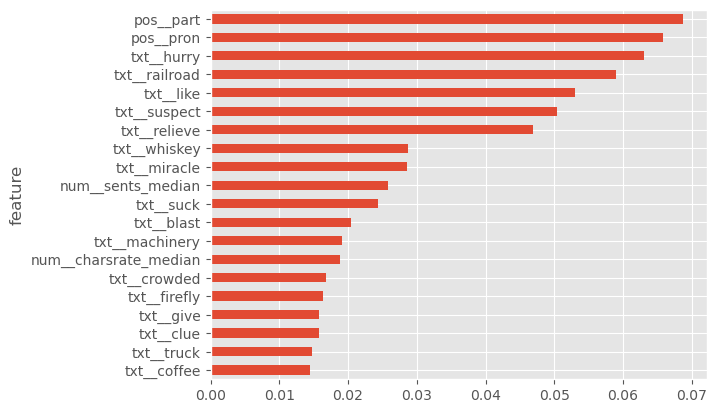

In [44]:
feature_names = pipeline[:-1].get_feature_names_out()
feature_importances = pipeline[-1].feature_importances_
fi = pd.DataFrame({'feature':feature_names, 'weight': feature_importances})
fi.feature = fi.feature.str[5:]

fi.sort_values(by='weight', ascending=False) \
  .head(20).sort_values(by='weight',ascending=True) \
  .plot(kind='barh', y='weight', x='feature', legend=False)
plt.show()


## Target correlation

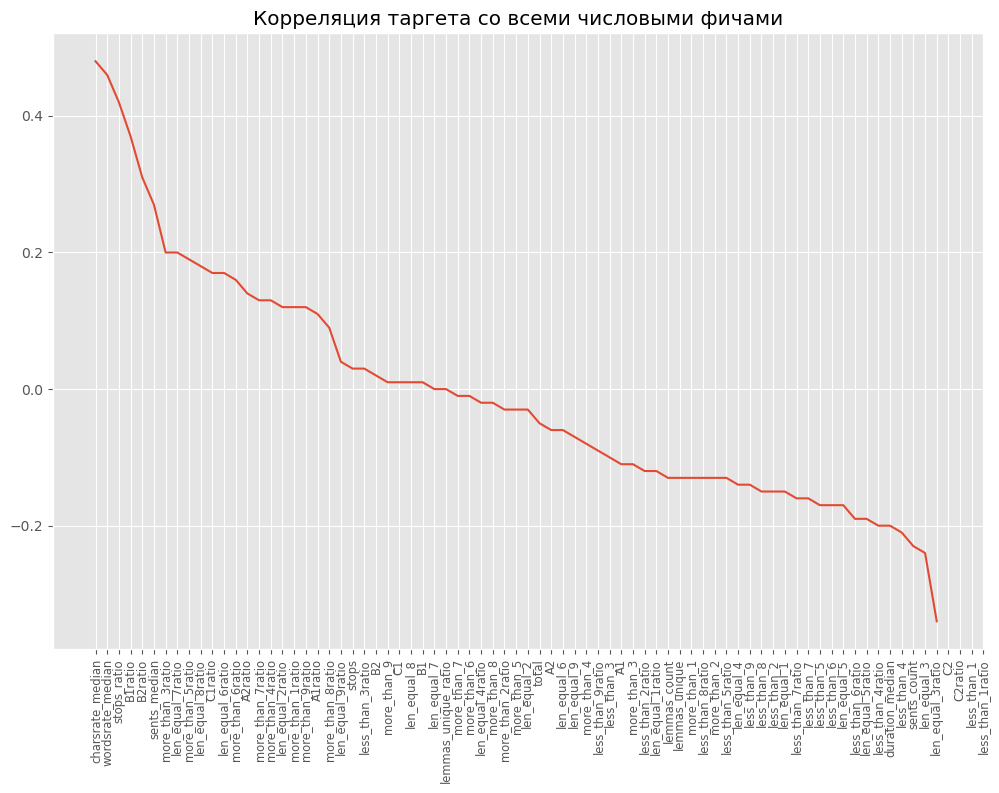

In [45]:
target_corr = movies.corrwith(movies.target)[:-1].round(2).sort_values(ascending=False)
plt.figure(figsize=(12,8))
target_corr.plot()
plt.xticks(rotation=90,size='small')
plt.title('Корреляция таргета со всеми числовыми фичами')
plt.xticks(range(0,len(target_corr)), labels=target_corr.index)
plt.show()

## Feature engineering

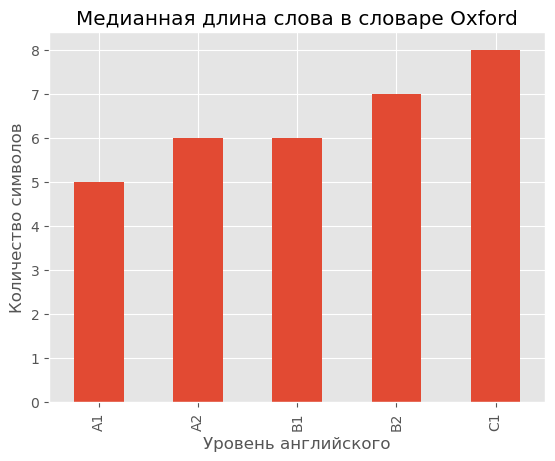

In [46]:
oxford_words['length'] = oxford_words.word.str.len()
oxford_words.groupby('level').length.median().plot(kind='bar')
plt.title('Медианная длина слова в словаре Oxford')
plt.ylabel('Количество символов')
plt.xlabel('Уровень английского')
plt.show()

In [47]:
# sns.pairplot(movies[num + ['target']], corner=True, hue='target')

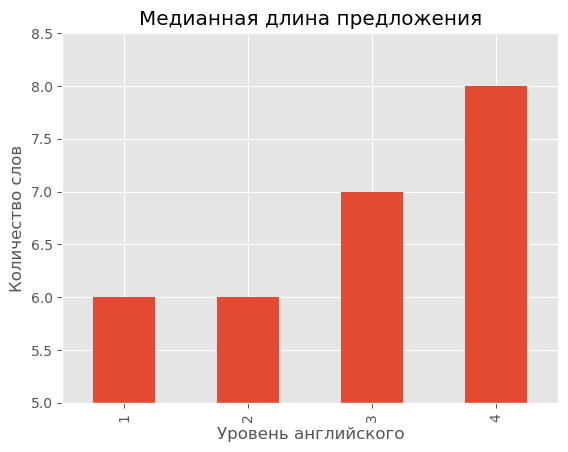

In [48]:
movies.groupby('target').sents_median.median().plot(kind='bar')
plt.title('Медианная длина предложения')
plt.ylim(5,8.5)
plt.ylabel('Количество слов')
plt.xlabel('Уровень английского')
plt.show()

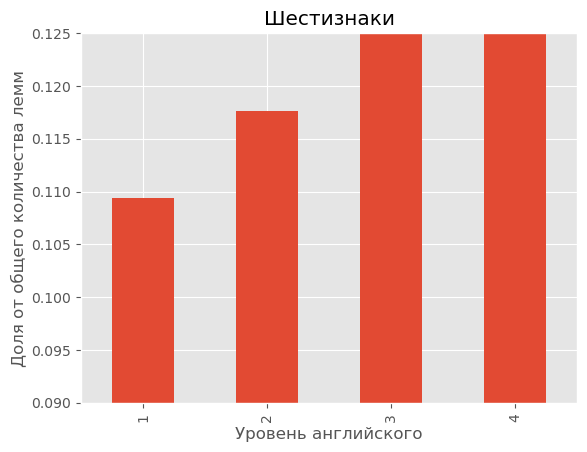

In [49]:
movies.groupby('target').len_equal_6ratio.median().plot(kind='bar')
plt.title('Шестизнаки')
plt.ylim(0.09,0.125)
plt.ylabel('Доля от общего количества лемм')
plt.xlabel('Уровень английского')
plt.show()

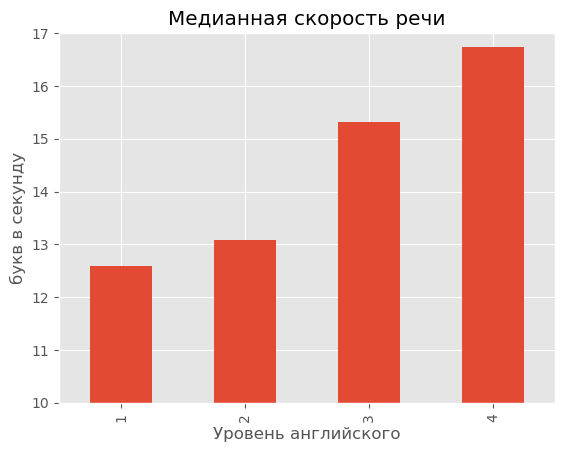

In [50]:
movies.groupby('target').charsrate_median.median().plot(kind='bar')
plt.title('Медианная скорость речи')
# plt.ylim(0.08,0.125)
plt.ylim(10,17)
plt.ylabel('букв в секунду')
plt.xlabel('Уровень английского')
plt.show()

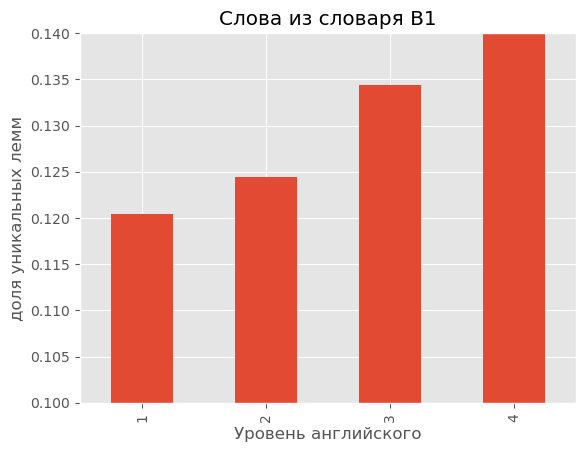

In [51]:
movies.groupby('target').B1ratio.median().plot(kind='bar')
plt.ylim(0.1,.14)
plt.title('Слова из словаря В1')
plt.ylabel('доля уникальных лемм')
plt.xlabel('Уровень английского')
plt.show()

**Кластеры KMeans**

При 4 кластерах есть заметное разделение на группы А2/В1 и В2/С1. Внутри этих групп разделение довольно плохо работает.


Но в целом добавление кластеризации в качестве признака несколько стабилизировало модель – при кросс-валидации разброс метрик стал меньше, на тесте немного улучшился скор.

В итоге было оставлено деление на три кластера.

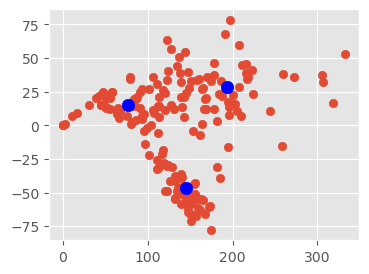

# Заключение

Для заказчика необходимо было найти решение определения уровня сложности английского языка в фильмах по субтитрам.

Заказчик предоставил данные:
- английские словари Oxford, в которых слова распределены по уровню сложности
- набор файлов-субтитров, рассортированных по каталогам в соответствии с уровнем сложности
- excel файл со список несортированных фильмов и указанием их уровня

Цель:
- создание модели определения уровня сложности

Задачи:
- изучение и обработка предоставленного материала
- обработка текста субтитров и подготовка для машинного обучения
- расчет и добавление дополнительных признаков
- тестирование модели и подбор гиперпараметров
- выделение наиболее удачных признаков
- обучение оптимальной модели на датасете с наиболее полезными признаками
- создание приложения на платформе streamlit для демонстрации решения



## The Oxford core by CEFR level

В словарях Oxford 3000 и 5000 содержатся наиболее важные слова, которые должен знать каждый, кто учит английский.

Словарь Oxford соответствует стандартам CEFR – The Common European Framework of Reference for Languages. Это общеевропейские компетенции владения иностранным языком: изучение, преподавание, оценка — система уровней владения иностранным языком, используемая в Европейском Союзе.

У нас словари представлены в виде pdf-файлов.
- прочитаем их,
- разобьем на строки,
- выделим слова,
- определим уровень
- сохраним, из какого словаря взяли слово
- удалим дубликаты, оставим те случаи, где слову присвоена более высокая сложность
- выгрузим в joblib для дальнейшего использования в приложении Streamlit

## Subtitles .srt

Субтитры у нас представлены в виде файлов .srt – это текстовые файлы, в которых информация представлены в таком виде:

        18
        00:04:59,796 --> 00:04:59,921
        - ( police radio chatter )
        - Man: What's the difference
    
То есть номер реплики, время и текст.

Файлы рассортированы по папкам, соответствующим уровням сложности языка.

Просканируем все файлы построчно:
- удалим из текста по возможности тэги, скобки, указания говорящего лица
- нетекстовые знаки, 
- лишние пробелы и переводы строки

Сохраним временные характеристики реплик:
- длительность реплики
- скорость речи в знаках в секунду
- скорость речи в словах в секунду

Соберем все в виде датасета для дальнейшей обработки.
    

## Excel labels processing

Часть файлов лежит в общем каталоге без указания уровня сложности. Для них заказчик предоставил excel-файл со списком фильмов и уровнями.
 
Загрузим файл и изучим его:
- удалим дубликаты
- поправим несовпадения названий
- из указанных уровней оставим более сложный вариант
- удалим фильмы, для которых нет информации по уровню сложности

## Lemmatization and feature engineering

Подготовим текст для машинного обучения:
- фильтруем имена собственные, стоп-слова, пунктуацию, цифры, урлы
- выполним лемматизацию – приведение слов к нормальной форме
- выделим морфологическую разметку

Добавим числовые признаки.

Слова (леммы):
- общее количество
- количество уникальных слов
- доля уников от общего количества

Предложения:
- количество предложений
- количество слов в предложениях
- медианная длина предложения

Сложность:
- подсчитаем количество уникальных слов каждого уровня
- долю слов каждой сложности относительно общего количества уников

Целевой признак перекодируем в порядовые числа от 0 до 5.

## Feature importances and correlation

Наибольший вклад в определение уровня ангийского вносят признаки:
- медианная длина предложения, количество слов
- медианная скорость речи, букв в секунду. Есть еще похожий признак – количество слов с секунду, но он не отражает длину слов.
- леммы, отфильтрованные от стоп-слов, именованых сущностей
- из частей речи заметно появление местоимений в числе 20 самых важных признаков.
- также проиллюстрировано заметно разное распределение слов уровня В1
- выявлена положительная корреляция между уровнем сложности и словами длиной 6 знаков
- кластеризация в качестве признака несколько стабилизировала модель – при кросс-валидации разброс метрик стал меньше, на тесте немного улучшился скор.

## Итоги

Обучена модель регресии XGBRegressor
- метрика RMSE на кроссвалидации 0.35
- метрика RMSE на тесте 0.61, что свидетельствует о переобучении модели
- предполагаю, что имеющего массива данных катастрофически недостаточно для качественной модели
- на большем количестве данных предполагаю не стоит использовать узкоспециализированные фичи типа слов равных по длине 6 знакам, искать более общие решения

Создано приложение на платформе Streamlit
- https://english-level.streamlit.app
- есть возможность загрузки пользовательких файлов .srt для определения уровня английского
- предусмотрено определение уровня английского в субтитрах на Youtube по ссылке
